* `capacity` – ограничение вместимости на маршрут
* `dimension` – количество точек, которые необходимо постетить
* `node_coord` – координаты точек
* `edge_weight` – веса путей между точками
* `demand` – сколько груза нужно забрать в точке
* `depot` – индекс точки, где находится депо

In [37]:
import numpy as np
import vrplib
import glob
import os
from pathlib import Path
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import pickle


np.random.seed(1)

In [2]:
def make_graph(weights: np.ndarray, coords: np.ndarray = None):
    vertices = np.arange(0, weights.shape[0])
    is_coords = True
    if not coords:
        is_coords = False
        coords = np.arange(weights.shape[0]) # делаем заглушку
    graph = dict(zip(vertices, coords))

    edges = {}
    pheromones = {}
    for idx, coords in graph.items():
        for idx_other, coords_other in graph.items():
            vertex_pair = (min(idx, idx_other), max(idx, idx_other))
            # считаем расстояния между всеми парами точек
            if is_coords:
                edge = np.sqrt(
                    (coords[0] - coords_other[0]) ** 2 + (coords[1] - coords_other[1]) ** 2
                )
            else:
                edge = weights[idx, idx_other]
            edges[vertex_pair] = edge

            # инициализируем феромоны единицей
            if idx != idx_other:
                pheromones[vertex_pair] = 0.1

    vertices = vertices[1:]  # убираем депо

    return vertices, edges, pheromones

In [3]:
def single_ant_solution(vertices, edges, init_capacity, demand, pheromones, alpha, beta):
    vertices = vertices.copy()
    final_path = []
    curr_capacity = None

    while len(vertices) != 0:
        path = []
        vertex = np.random.choice(vertices)  # муравей начинает из случайной вершины
        curr_capacity = init_capacity - demand[vertex]  # оставшаяся вместимость
        path.append(vertex)
        vertices = vertices[vertices != vertex]

        while len(vertices) != 0:
            # числитель в формуле
            vfunc = np.vectorize(
                lambda x: ((pheromones[(min(x, vertex), max(x, vertex))]) ** alpha)
                * ((1 / edges[(min(x, vertex), max(x, vertex))]) ** beta)
            )
            probabilities = vfunc(vertices)
            probabilities = np.nan_to_num(probabilities, nan=0)

            # вероятности перехода муравья из текущей вершины в другие
            probabilities = probabilities / np.sum(probabilities)

            # переходим в случайную вершину с учетом вероятностей
            vertex = np.random.choice(
                vertices, p=probabilities
            )
            curr_capacity = curr_capacity - demand[vertex] # оставшаяся вместимость

            # проверяем, что можем забрать посылку
            if curr_capacity > 0:
                path.append(vertex)
                vertices = vertices[vertices != vertex]
            else:
                break

        final_path.append(path)

    return final_path

In [4]:
def calc_distance(path, edges):
    final_distance = 0
    for single_path in path:
        start = 0 # стартуем из депо
        for vertex in single_path:
            end = vertex
            final_distance += edges[min(start, end), max(start, end)]
            start = end
        end = 0 # возвращаемся в депо
        final_distance += edges[min(start, end), max(start, end)]
    return final_distance

In [5]:
def update_pheromones(pheromones, solutions, distances, Q, rho):
    # обновление значений феромонов
    L = sum(distances) / len(solutions)  # среднее пройденное расстояние
    delta_pheromones = Q / L # добавка феромона
    pheromones = {
        idx: (1 - rho) * val + delta_pheromones for (idx, val) in pheromones.items()
    }

    return pheromones

In [6]:
def update_best_path(paths, distances, best_path, best_distance):
    paths, distances = zip(*sorted(zip(paths, distances), key=lambda x: x[1]))
    if best_path != None:
        if distances[0] < best_distance:
            best_path = paths[0]
            best_distance = distances[0]
    else:
        best_path = paths[0]
        best_distance = distances[0]

    return best_path, best_distance

In [7]:
def optimize(instance, iterations, ants, alpha, beta, rho, Q):
  best_path = None
  best_distance = None
  vertices, edges, pheromones = make_graph(instance["edge_weight"]) # instance["node_coord"]

  for i in range(iterations):
    paths = []
    distances = []
    for _ in range(ants):
        path = single_ant_solution(vertices, edges, instance["capacity"], instance["demand"], pheromones, alpha, beta)
        paths.append(path)
        distances.append(calc_distance(path, edges))

    update_pheromones(pheromones, paths, distances, Q, rho)
    best_path, best_distance = update_best_path(paths, distances, best_path, best_distance)

  return best_path, best_distance

In [8]:
def calc_error(best_distance, optim_distance):
    return 100 * abs(optim_distance - best_distance) / optim_distance

In [57]:
default_params = [7, 12, 0.2, 200]
iterations = 1000
ants = 20

Перебор параметров осуществлялся в отдельном скрипте, загрузим файлы с подобранными параметрами для каждого из сетов:

$\alpha$ – важность феромонов  
$\beta$ – важность расстояния  
$\rho$ – скорость испарения феромонов  
$Q$ – важность среднего пройденного расстояния

In [31]:
with open(
    "/Users/ivsidorov/Documents/Учеба/Семинар наставника/all_params.pkl", "rb"
) as f:
    params_a = pickle.load(f)

with open(
    "/Users/ivsidorov/Documents/Учеба/Семинар наставника/all_params_b.pkl", "rb"
) as f:
    params_b = pickle.load(f)

with open(
    "/Users/ivsidorov/Documents/Учеба/Семинар наставника/all_params_e.pkl", "rb"
) as f:
    params_e = pickle.load(f)

In [58]:
def get_optimization_statistics(task_path, iterations, ants, all_params):
    cnt = 0
    for path in glob.glob(task_path):
        cnt += 1

    dimensions = []
    errors = []
    times = []
    for path in tqdm(glob.glob(task_path), total=cnt):
        try:
            path = Path(path)
            instance = vrplib.read_instance(path)
            solution = vrplib.read_solution(
                os.path.join(path.parent, path.stem + ".sol")
            )

            start_time = time.time()
            try:
                params = all_params[str(path.absolute())]
            except KeyError:
                params = default_params
            _, best_distance = optimize(
                instance,
                iterations=iterations,
                ants=ants,
                alpha=params[0],
                beta=params[1],
                rho=params[2],
                Q=params[3],
            )
            end_time = time.time()
            elapsed_time = end_time - start_time
            times.append(elapsed_time)

            error = calc_error(best_distance, solution["cost"])
            errors.append(error)

            dimension = instance["dimension"]
            dimensions.append(dimension)
        except ValueError:
            print(f"Optimization for {instance['name']} failed")

    dimensions, errors, times = zip(
        *sorted(zip(dimensions, errors, times), key=lambda x: x[0])
    )

    return dimensions, errors, times

### Задача A

In [52]:
dimensions, errors, times = get_optimization_statistics(
    task_path="data/A/*.vrp", iterations=iterations, ants=ants, all_params=params_a
)

  0%|          | 0/27 [00:00<?, ?it/s]

/var/folders/7l/fhtrvm8s5wnb9rbtn9nqc3vh0000gp/T/ipykernel_10468/2724730109.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  * ((1 / edges[(min(x, vertex), max(x, vertex))]) ** beta)


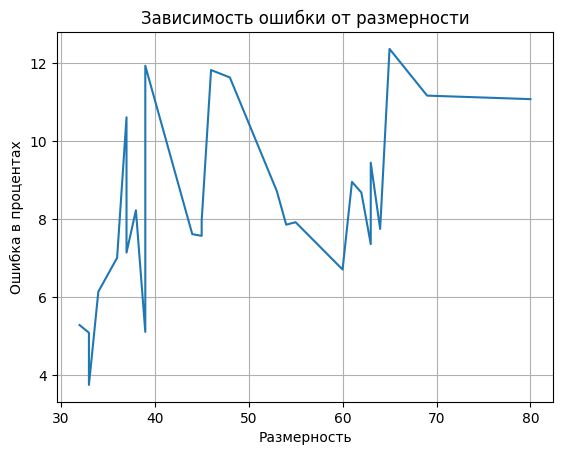

In [53]:
plt.plot(dimensions, errors)
plt.title("Зависимость ошибки от размерности")
plt.xlabel("Размерность")
plt.ylabel("Ошибка в процентах")
plt.grid()
plt.show()

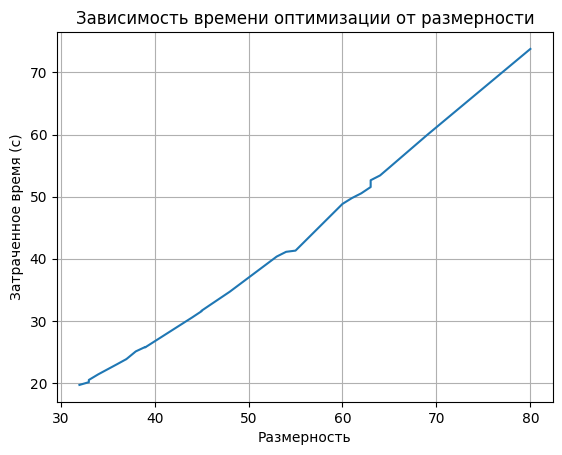

In [54]:
plt.plot(dimensions, times)
plt.title("Зависимость времени оптимизации от размерности")
plt.xlabel("Размерность")
plt.ylabel("Затраченное время (с)")
plt.grid()
plt.show()

### Задача B

In [59]:
dimensions, errors, times = get_optimization_statistics(
    task_path="data/B/*.vrp", iterations=iterations, ants=ants, all_params=params_b
)

  0%|          | 0/23 [00:00<?, ?it/s]

/var/folders/7l/fhtrvm8s5wnb9rbtn9nqc3vh0000gp/T/ipykernel_10468/2724730109.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  * ((1 / edges[(min(x, vertex), max(x, vertex))]) ** beta)
/Users/ivsidorov/Documents/Учеба/Семинар наставника/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Optimization for B-n64-k9 failed
Optimization for B-n51-k7 failed
Optimization for B-n56-k7 failed


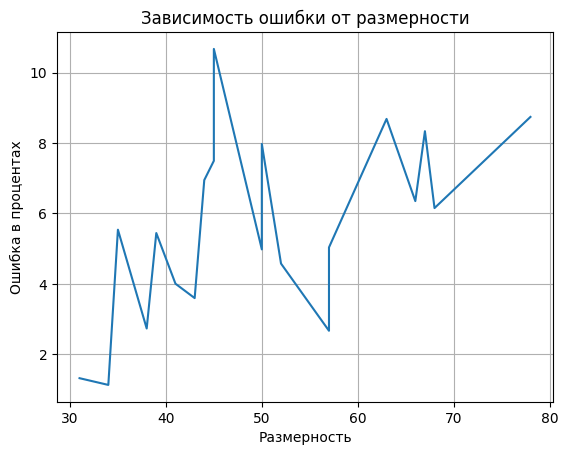

In [60]:
plt.plot(dimensions, errors)
plt.title("Зависимость ошибки от размерности")
plt.xlabel("Размерность")
plt.ylabel("Ошибка в процентах")
plt.grid()
plt.show()

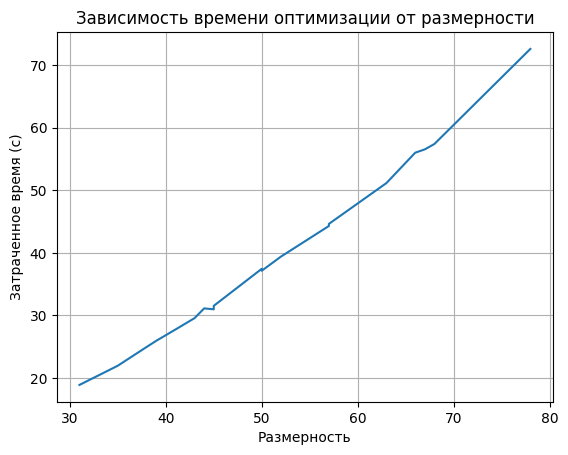

In [61]:
plt.plot(dimensions, times)
plt.title("Зависимость времени оптимизации от размерности")
plt.xlabel("Размерность")
plt.ylabel("Затраченное время (с)")
plt.grid()
plt.show()

### Задача E

In [62]:
dimensions, errors, times = get_optimization_statistics(
    task_path="data/E/*.vrp", iterations=iterations, ants=ants, all_params=params_e
)

  0%|          | 0/13 [00:00<?, ?it/s]

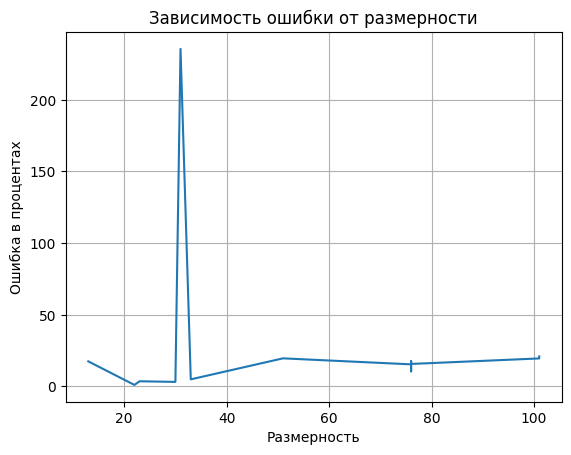

In [63]:
plt.plot(dimensions, errors)
plt.title("Зависимость ошибки от размерности")
plt.xlabel("Размерность")
plt.ylabel("Ошибка в процентах")
plt.grid()
plt.show()

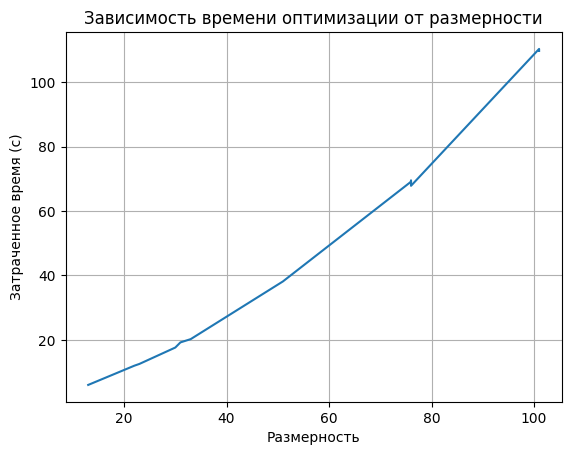

In [64]:
plt.plot(dimensions, times)
plt.title("Зависимость времени оптимизации от размерности")
plt.xlabel("Размерность")
plt.ylabel("Затраченное время (с)")
plt.grid()
plt.show()

### Визуализация маршрутов

In [400]:
def draw_routes(var, cr):
    x, y = [], []
    for r in range(len(cr)):
        tx, ty = [], []
        tx.append(var[0][0])
        ty.append(var[0][1])
        for i in range(len(cr[r])):
            if cr[r][i] != 0:
                tx.append(var[cr[r][i]][0])
                ty.append(var[cr[r][i]][1])
        tx.append(var[0][0])
        ty.append(var[0][1])
        x.append(tx)
        y.append(ty)
    plt.figure()
    for i in range(len(cr)):
        plt.plot(x[i], y[i], 'o-', label='Route ' + str(i + 1))
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [377]:
instance = vrplib.read_instance("data/A/A-n32-k5.vrp")
best_path, best_distance = optimize(instance)

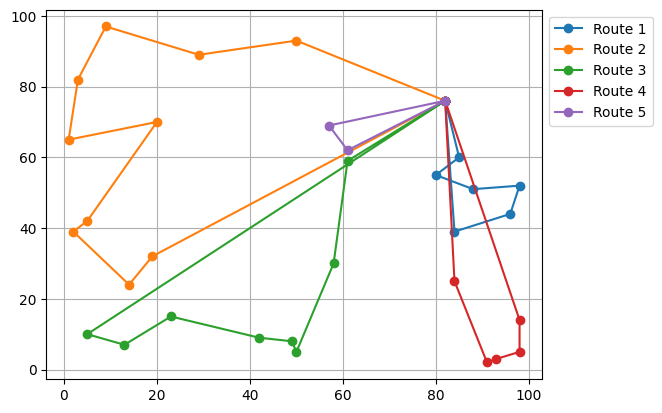

In [401]:
draw_routes(instance["node_coord"], best_path)

##### Ground Truth

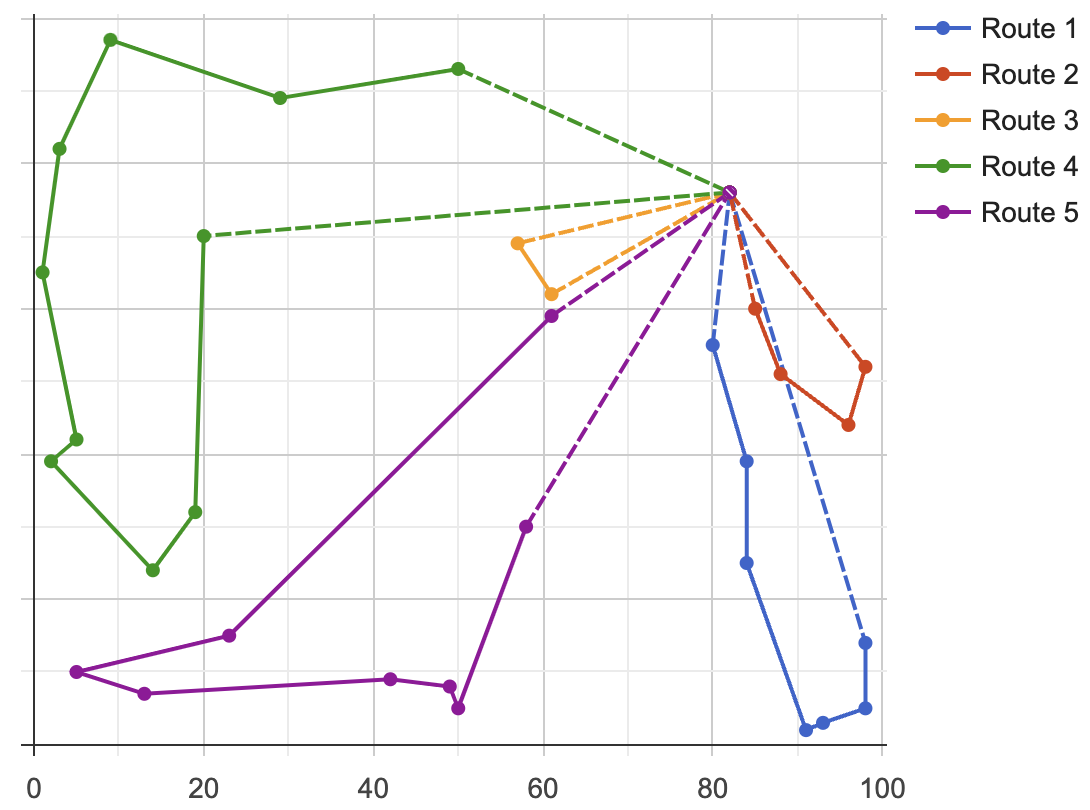